https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [ ]:
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse,aic

**BMW**

In [ ]:
start_date = '1996-11-09'
end_date = '2020-11-30'

bmwdf = pdr.data.DataReader( "BMW.DE", 'yahoo', start_date, end_date)

In [ ]:
from google.colab import files
bmwdf.to_csv('bmw.csv') 

In [ ]:
bmwdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6170 entries, 1996-11-11 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       6170 non-null   float64
 1   Low        6170 non-null   float64
 2   Open       6170 non-null   float64
 3   Close      6170 non-null   float64
 4   Volume     6170 non-null   float64
 5   Adj Close  6170 non-null   float64
dtypes: float64(6)
memory usage: 337.4 KB


Granger casuality test. test the null hypothesis that coeff of past values in the regression equation is 0. the past values of time series (x) do not cause the other series (y). if p value obtained from the test is < 0.05 reject null hypthesis

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    bmwdf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in bmwdf.columns:
        for r in bmwdf.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            bmwdf.loc[r, c] = min_p_value
    bmwdf.columns = [var + '_x' for var in variables]
    bmwdf.index = [var + '_y' for var in variables]
    return bmwdf

grangers_causation_matrix(bmwdf, variables = bmwdf.columns)        

,High_x,Low_x,Open_x,Close_x,Volume_x,Adj Close_x
High_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Low_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Open_y,0.0000,0.0000,1.0000,0.0000,0.3538,0.0000
Close_y,0.1121,0.0000,0.0024,1.0000,0.0649,0.0003
Volume_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
Adj Close_y,0.0672,0.0003,0.0073,0.0001,0.1895,1.0000


splitting to training and testing data
The VAR model will be fitted on df_train and then used to forecast the next 4 observations. These forecasts will be compared against the actuals present in test data.

In [ ]:
nobs = 4
bmwtrain, bmwtest = bmwdf[0:-nobs], bmwdf[-nobs:]

# Check size
print(bmwtrain.shape)
print(bmwtest.shape)

(6166, 6)
(4, 6)


checking for stationarity and make time series stationarity

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [ ]:
# ADF Test on each column
for name, column in bmwtrain.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.88
 No. Lags Chosen       = 1
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.3415. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8487
 No. Lags Chosen       = 6
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.3566. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root.

In [ ]:
#first differencing
bmwdf_differenced = bmwtrain.diff().dropna()

In [ ]:
for name, column in bmwdf_differenced.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -71.5739
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -33.0172
 No. Lags Chosen       = 5
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

selecting the order of VAR Model

In [ ]:
bmwmodel = VAR(bmwdf_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = bmwmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  20.029647641573593
BIC :  20.075480251932206
FPE :  499764550.97633123
HQIC:  20.04554225973363 

Lag Order = 2
AIC :  19.509931061325062
BIC :  19.59506052395285
FPE :  297204525.8135792
HQIC:  19.539453956932594 

Lag Order = 3
AIC :  19.276180875449402
BIC :  19.400618048676254
FPE :  235255094.69547814
HQIC:  19.31933603722077 

Lag Order = 4
AIC :  19.121782560282128
BIC :  19.28553830726349
FPE :  201597325.46687075
HQIC:  19.178573978757953 

Lag Order = 5
AIC :  19.00636787052248
BIC :  19.209453059242307
FPE :  179622571.12185684
HQIC:  19.076799538068816 

Lag Order = 6
AIC :  18.938060464438347
BIC :  19.180485967712016
FPE :  167762749.12740418
HQIC:  19.022136375247776 

Lag Order = 7
AIC :  18.889910813379487
BIC :  19.17168750885675
FPE :  159876496.03082916
HQIC:  18.98763496347229 

Lag Order = 8
AIC :  18.856599067521167
BIC :  19.177737837689087
FPE :  154638560.4577878
HQIC:  18.967975454746426 

Lag Order = 9
AIC :  18.82254337214201
BIC :  19.

train model of selected order(p)

In [ ]:
bmwmodel_fitted = bmwmodel.fit(9)
bmwmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     07:54:37
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    19.1831
Nobs:                     6156.00    HQIC:                   18.9476
Log likelihood:          -110016.    FPE:                1.49461e+08
AIC:                      18.8225    Det(Omega_mle):     1.41694e+08
--------------------------------------------------------------------
Results for equation High
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.006429         0.009958            0.646           0.519
L1.High             -0.687805         0.027719          -24.813           0.000
L1.Low               0.096701         0.026299            3.677  

checking for serial Correlation of residuals using Durbin Watson Statistic
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(bmwmodel_fitted.resid)
for col, val in zip(bmwdf.columns, out):
  print(col, ':', round(val, 2))

High : 2.01
Low : 2.01
Open : 2.02
Close : 2.0
Volume : 2.01
Adj Close : 2.0


forecase VAR model using statsmodels
In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [ ]:
lag_order = bmwmodel_fitted.k_ar
print(lag_order)
forecast_input = bmwdf_differenced.values[-lag_order:]
forecast_input

9


array([[-9.99450684e-03,  4.59999084e-01, -8.99963379e-02,
         3.60000610e-01, -1.94268000e+05,  3.60000610e-01],
       [ 2.39997864e-01,  1.06000519e+00,  9.69993591e-01,
         4.00009155e-02, -2.82169000e+05,  4.00009155e-02],
       [ 2.55000305e+00,  9.89997864e-01,  8.70002747e-01,
         2.05000305e+00,  5.25662000e+05,  2.05000305e+00],
       [-5.80001831e-01,  8.69995117e-01,  1.38999939e+00,
         5.99975586e-02, -9.84888000e+05,  5.99975586e-02],
       [ 9.19998169e-01,  8.00018311e-02, -3.00003052e-01,
         1.02000427e+00,  7.70350000e+04,  1.02000427e+00],
       [ 9.99984741e-02,  9.40002441e-01,  8.70002747e-01,
         1.29997253e-01,  4.10429000e+05,  1.29997253e-01],
       [ 3.80004883e-01,  3.49998474e-01,  7.90000916e-01,
         1.50001526e-01, -2.91190000e+04,  1.50001526e-01],
       [ 3.99932861e-02,  2.09999084e-01, -9.99984741e-02,
        -2.60002136e-01, -1.74038000e+05, -2.60002136e-01],
       [ 2.16000366e+00,  1.00000000e+00,  9.499

In [ ]:
# Forecast
fc = bmwmodel_fitted.forecast(y=forecast_input, steps=nobs)
bmwdf_forecast = pd.DataFrame(fc, index=bmwdf.index[-nobs:], columns=bmwdf.columns + '_1d')
bmwdf_forecast

,High_1d,Low_1d,Open_1d,Close_1d,Volume_1d,Adj Close_1d
Date,,,,,,
2020-11-25,0.715574,1.340764,1.585781,0.191882,-206965.348436,0.190073
2020-11-26,-0.053436,0.113046,0.117083,0.035410,-299278.546284,0.031782
2020-11-27,0.332364,0.253788,0.220201,0.264719,146103.310899,0.183699
2020-11-30,-0.226527,-0.237813,-0.131079,-0.317191,-24936.939518,-0.260862


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data. (1)

In [ ]:
def invert_transformation(bmwdf_train, bmwdf_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    bmwdf_fc = bmwdf_forecast.copy()
    columns = bmwdf_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        #if first_diff:
        # Roll back 1st Diff
        bmwdf_fc[str(col)+'_forecast'] = bmwdf_train[col].iloc[-1] + bmwdf_fc[str(col)+'_1d'].cumsum()
    return bmwdf_fc

In [ ]:
bmwdf_results = invert_transformation(bmwtrain, bmwdf_forecast, first_diff=True)        
bmwdf_results.loc[:, ['High_forecast', 'Low_forecast', 'Open_forecast', 'Close_forecast',
                   'Volume_forecast', 'Adj Close_forecast']]

,High_forecast,Low_forecast,Open_forecast,Close_forecast,Volume_forecast,Adj Close_forecast
Date,,,,,,
2020-11-25,77.395574,75.940763,76.435780,76.871882,1.637644e+06,76.870073
2020-11-26,77.342138,76.053808,76.552862,76.907292,1.338365e+06,76.901855
2020-11-27,77.674501,76.307596,76.773063,77.172011,1.484468e+06,77.085554
2020-11-30,77.447975,76.069783,76.641984,76.854820,1.459531e+06,76.824692


In [ ]:
bmwdf.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-24,76.680000,74.599998,74.849998,76.680000,1844609.0,76.680000
2020-11-25,77.309998,74.639999,77.000000,75.400002,1489748.0,75.400002
2020-11-26,75.320000,73.669998,75.300003,74.129997,1215517.0,74.129997
2020-11-27,73.809998,72.599998,73.769997,73.089996,1699488.0,73.089996
2020-11-30,73.760002,72.250000,72.510002,73.040001,1921018.0,73.040001


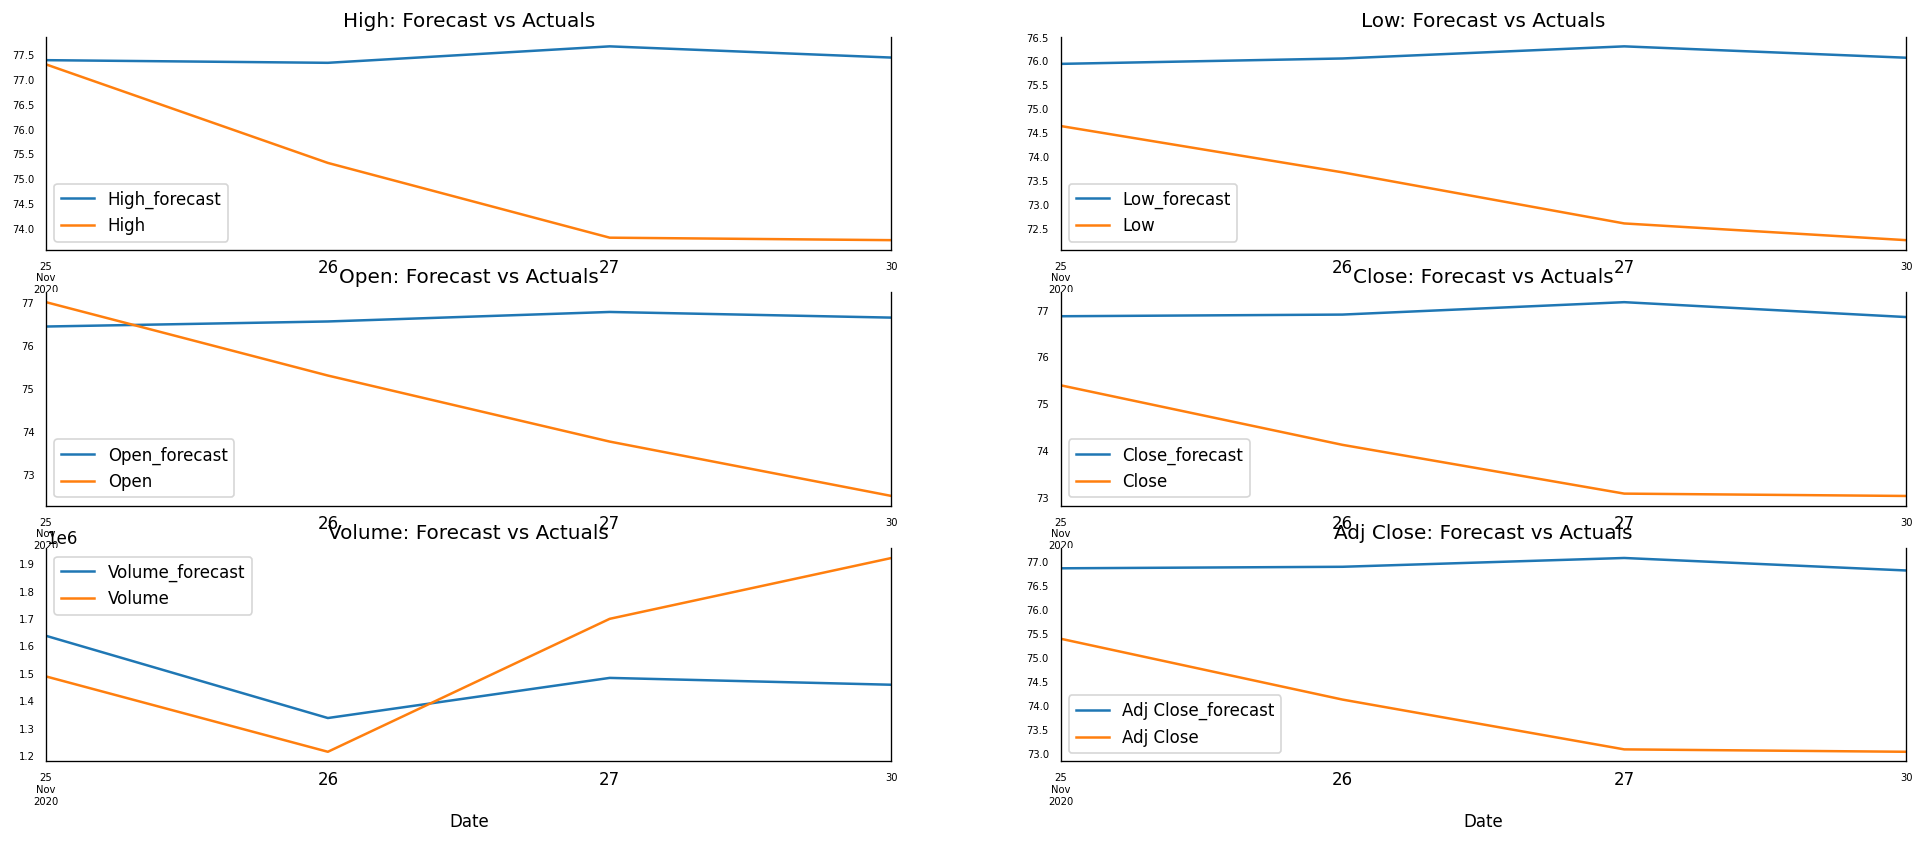

In [ ]:
fig, axes = plt.subplots(nrows=int(len(bmwdf.columns)/2), ncols=2, dpi=120, figsize=(20,8))
for i, (col,ax) in enumerate(zip(bmwdf.columns, axes.flatten())):
    bmwdf_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    bmwtest[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

Evaluate forecast

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mae': mae,'rmse':rmse, 'minmax':minmax})

print('Forecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(bmwdf_results['Close_forecast'].values, bmwtest['Close'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Close
mae :  3.0365
rmse :  3.2053
minmax :  0.0394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


**TESLA**

In [ ]:
start_date = '2010-06-30'
end_date = '2020-11-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
tesladf = pdr.data.DataReader( "TSLA", 'yahoo', start_date, end_date)

In [ ]:
from google.colab import files
tesladf.to_csv('tesla.csv') 
#files.download('tesla.csv')

In [ ]:
tesladf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2624 entries, 2010-06-30 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2624 non-null   float64
 1   Low        2624 non-null   float64
 2   Open       2624 non-null   float64
 3   Close      2624 non-null   float64
 4   Volume     2624 non-null   float64
 5   Adj Close  2624 non-null   float64
dtypes: float64(6)
memory usage: 143.5 KB


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
t_maxlag=12
t_test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, t_test='ssr_chi2test', verbose=False):
  tesladf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in tesladf.columns:
    for r in tesladf.index:
      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][t_test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      tesladf.loc[r, c] = min_p_value
  tesladf.columns = [var + '_x' for var in variables]
  tesladf.index = [var + '_y' for var in variables]
  return tesladf

grangers_causation_matrix(tesladf, variables = tesladf.columns)    

,High_x,Low_x,Open_x,Close_x,Volume_x,Adj Close_x
High_y,1.0,0.0,0.0,0.0,0.0000,0.0
Low_y,0.0,1.0,0.0,0.0,0.0000,0.0
Open_y,0.0,0.0,1.0,0.0,0.0004,0.0
Close_y,0.0,0.0,0.0,1.0,0.1319,1.0
Volume_y,0.0,0.0,0.0,0.0,1.0000,0.0
Adj Close_y,0.0,0.0,0.0,1.0,0.1319,1.0


cointegration test error - LinAlgError("Singular matrix")
This means that the system of equations you are trying to solve does not have a unique solution; linalg.solve can't handle this.

Train and test

In [ ]:
tnobs = 4
teslatrain, teslatest = tesladf[0:-tnobs], tesladf[-tnobs:]
# Check size
print(teslatrain.shape)
print(teslatest.shape)  # (4, 8)

(2620, 6)
(4, 6)


Stationarity Test

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
  r = adfuller(series, autolag='AIC')
  output = {'test_statistic':round(r[0], 4),'pvalue':round(r[1], 4),'n_lags':round(r[2], 4),'n_obs':r[3]}
  p_value = output['pvalue'] 
  def adjust(val, length= 6): return str(val).ljust(length)
# Print Summary
  print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
  print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
  print(f' Significance Level    = {signif}')
  print(f' Test Statistic        = {output["test_statistic"]}')
  print(f' No. Lags Chosen       = {output["n_lags"]}')

  if p_value <= signif:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.")   

In [ ]:
# ADF Test on each column
for name, column in teslatrain.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')
#only Volume is stationary - I am more interested on Close

    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 5.7924
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 6.687
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

In [ ]:
#First difference
tesladifferenced = teslatrain.diff().dropna()

In [ ]:
# ADF Test First Differences Dataframe
for name, column in tesladifferenced.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')
#everything is stationary

    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9635
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2061
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [ ]:
teslamodel = VAR(tesladifferenced)
#what noticed is that it keeps giving errors on lags. Previously these are not working
#1,2,3,4,5,6,7,8,9 shows an error of lag leading minor so left with 3,4,5,7,8,9
#this error can still occur since 3,4,5,7,8,9 would not work and keep finding the number that would work for it
for i in [3,4,5,7,8,9]:
  result = teslamodel.fit(i)
  result = teslamodel.fit(i)
  print('Lag Order =', i)
  print('AIC : ', result.aic)
  print('BIC : ', result.bic)
  print('FPE : ', result.fpe)
  print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 3
AIC :  7.242584294787395
BIC :  7.498360974922635
FPE :  1397.7035220268315
HQIC:  7.335229518305991 

Lag Order = 4
AIC :  6.4464331168213045
BIC :  6.783088147978036
FPE :  630.4517413284167
HQIC:  6.568375769050795 

Lag Order = 5
AIC :  6.226322226785905
BIC :  6.643906948407273
FPE :  505.89487911655186
HQIC:  6.377582044005498 

Lag Order = 7
AIC :  6.128117133491538
BIC :  6.707715466003886
FPE :  458.58010277451234
HQIC:  6.338070573259042 

Lag Order = 8
AIC :  5.864469544608364
BIC :  6.525151903550357
FPE :  352.30454568206846
HQIC:  6.1037994838741465 

Lag Order = 9
AIC :  4.80182378437316
BIC :  5.543641721194816
FPE :  121.73678633307699
HQIC:  5.070550043297475 



train VAR model with the selected order

In [ ]:
teslamodel_fitted = teslamodel.fit(9)
teslamodel_fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1431: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1453: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.stderr


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     08:03:59
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    5.54364
Nobs:                     2610.00    HQIC:                   5.07055
Log likelihood:          -28157.0    FPE:                    121.737
AIC:                      4.80182    Det(Omega_mle):         105.156
--------------------------------------------------------------------
Results for equation High
                  coefficient              std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                0.082558                0.066791            1.236           0.216
L1.High             -0.438981                0.041863          -10.486           0.000
L1.Low               0.711912        

checking for serial correlation of residuals using durbin watcon statistic

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(teslamodel_fitted.resid)

for col, val in zip(tesladf.columns, out):
    print(col, ':', round(val, 2))

High : 1.98
Low : 2.0
Open : 1.98
Close : 1.97
Volume : 2.01
Adj Close : 1.97


In [ ]:
teslag_order = teslamodel_fitted.k_ar
print(teslag_order)
tforecast_input = tesladifferenced.values[-teslag_order:]
tforecast_input

9


array([[-1.38998413e+00,  1.45499878e+01, -3.63998413e+00,
         6.77001953e+00, -1.29265000e+07,  6.77001953e+00],
       [ 4.29998779e+00, -1.05999756e+00, -1.40002441e+00,
        -5.36999512e+00,  2.49740000e+06, -5.36999512e+00],
       [-1.04700012e+01, -7.85998535e+00, -4.19998169e+00,
        -3.26000977e+00, -8.40000000e+04, -3.26000977e+00],
       [-7.99865723e-02,  2.42999268e+00, -1.92001343e+00,
        -4.10003662e-01,  7.06750000e+06, -4.10003662e-01],
       [ 4.95499878e+01,  2.89200134e+01,  5.12400208e+01,
         3.35199890e+01,  3.43497000e+07,  3.35199890e+01],
       [ 3.40000000e+01,  1.04899902e+01, -1.18200073e+01,
         4.50300293e+01,  1.68557000e+07,  4.50300293e+01],
       [ 1.26099854e+01,  4.40700073e+01,  4.36499939e+01,
         1.26299744e+01, -1.55687000e+07,  1.26299744e+01],
       [-6.10998535e+00,  1.48999023e+00,  5.98999023e+00,
        -9.66000366e+00, -2.95634000e+07, -9.66000366e+00],
       [ 2.35000000e+01,  1.27300110e+01,  5.510

In [ ]:
tfc = teslamodel_fitted.forecast(y = forecast_input, steps = tnobs)
teslaforecast = pd.DataFrame(tfc, index = tesladf.index[-tnobs:], columns = tesladf.columns + '_1d')
teslaforecast

,High_1d,Low_1d,Open_1d,Close_1d,Volume_1d,Adj Close_1d
Date,,,,,,
2020-11-24,1.545963,1.411192,1.658955,0.845517,1.757107e+06,0.845517
2020-11-25,0.625396,1.319905,1.562352,0.843484,-1.778733e+06,0.843484
2020-11-27,0.183795,-0.193217,-0.395039,-0.032436,-5.135271e+04,-0.032436
2020-11-30,0.866760,0.916248,0.618162,1.353250,1.495461e+05,1.353250


In [ ]:
def invert_transformation(teslatrain, teslaforecast, first_diff=False):
    tesladf_fc = teslaforecast.copy()
    columns = teslatrain.columns
    for col in columns:
      # Roll back 1st Diff
      tesladf_fc[str(col)+'_forecast'] = teslatrain[col].iloc[-1] + tesladf_fc[str(col)+'_1d'].cumsum()
    return tesladf_fc

In [ ]:
tesladf_results = invert_transformation(teslatrain, teslaforecast, first_diff=True)        
tesladf_results.loc[:, ['High_forecast', 'Low_forecast', 'Open_forecast', 'Close_forecast',
                   'Volume_forecast', 'Adj Close_forecast']]

,High_forecast,Low_forecast,Open_forecast,Close_forecast,Volume_forecast,Adj Close_forecast
Date,,,,,,
2020-11-24,527.545963,503.201201,505.158955,522.695493,5.201741e+07,522.695493
2020-11-25,528.171359,504.521106,506.721307,523.538977,5.023867e+07,523.538977
2020-11-27,528.355154,504.327889,506.326268,523.506541,5.018732e+07,523.506541
2020-11-30,529.221915,505.244137,506.944430,524.859791,5.033687e+07,524.859791


In [ ]:
tesladf.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-23,526.000000,501.790009,503.500000,521.849976,50260300.0,521.849976
2020-11-24,559.989990,526.200012,540.400024,555.380005,53648500.0,555.380005
2020-11-25,574.000000,545.369995,550.059998,574.000000,48930200.0,574.000000
2020-11-27,598.780029,578.450012,581.159973,585.760010,37561100.0,585.760010
2020-11-30,607.799988,554.510010,602.210022,567.599976,63003100.0,567.599976


Plot forecast vs actuals

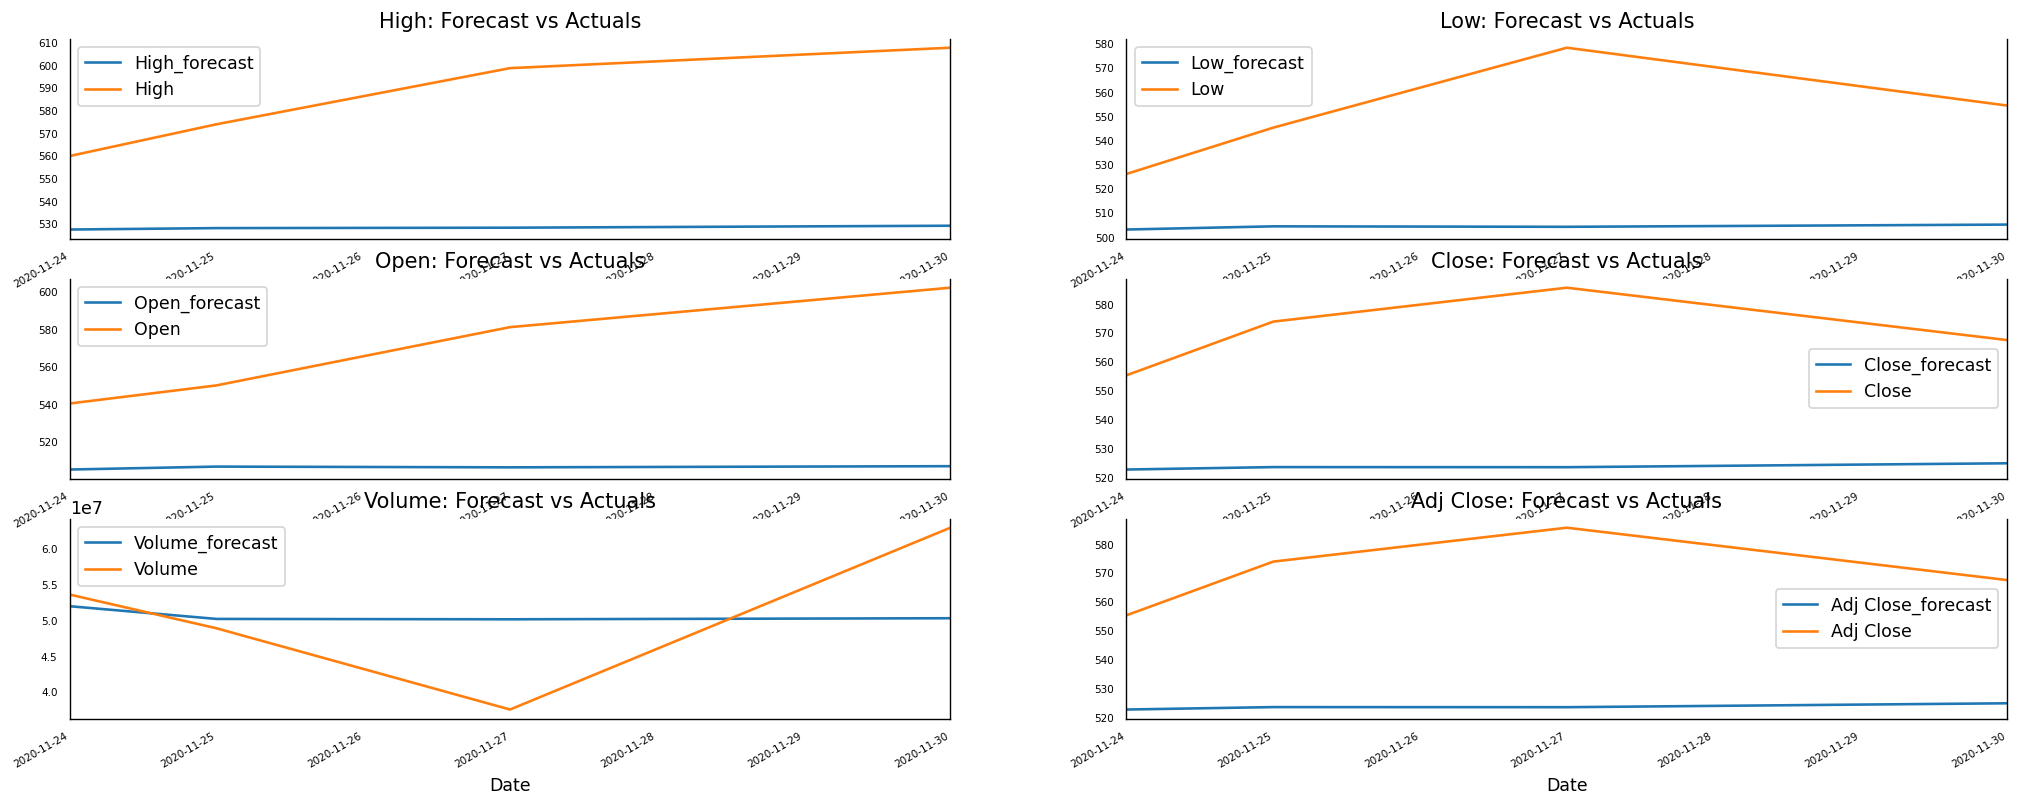

In [ ]:
fig, axes = plt.subplots(nrows=int(len(tesladf.columns)/2), ncols=2, dpi=125, figsize=(20,8))
for i, (col,ax) in enumerate(zip(tesladf.columns, axes.flatten())):
    tesladf_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    teslatest[col][-tnobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

Evaluate forecast

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mae': mae,'rmse':rmse, 'minmax':minmax})

print('Forecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(tesladf_results['Close_forecast'].values, teslatest['Close'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Close
mae :  47.0348
rmse :  48.2618
minmax :  0.0821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


**CO2**

In [ ]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1vZGR58aOIt4b58EyFFzqf2SdH0XVFLw-/view?usp=sharing'

In [ ]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('carbonemissions.csv')
carbondf = pd.read_csv('carbonemissions.csv')

In [ ]:
from google.colab import files
carbondf.to_csv('carbonemissions.csv') 

In [ ]:
carbondf.drop(['iso_code','co2_growth_abs','consumption_co2','trade_co2','trade_co2_share','co2_per_capita','consumption_co2_per_capita','cumulative_co2','share_global_cumulative_co2','consumption_co2_per_gdp','co2_per_unit_energy','cement_co2','coal_co2','flaring_co2','gas_co2','oil_co2','cement_co2_per_capita','coal_co2_per_capita','flaring_co2_per_capita','gas_co2_per_capita','oil_co2_per_capita','total_ghg','ghg_per_capita','methane','methane_per_capita','nitrous_oxide','nitrous_oxide_per_capita','primary_energy_consumption','energy_per_capita','energy_per_gdp','population','gdp','co2_growth_prct'], axis=1, inplace=True)

In [ ]:
carbondf = carbondf[carbondf.country == 'United States']

In [ ]:
carbondf.drop(['country','year'], axis=1, inplace=True)

In [ ]:
#carbondf.drop('year', axis=1, inplace=True)

In [ ]:
carbondf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 22625 to 22892
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   co2               268 non-null    float64
 1   share_global_co2  268 non-null    float64
 2   co2_per_gdp       197 non-null    float64
dtypes: float64(3)
memory usage: 8.4 KB


In [ ]:
#carbondf = carbondf[carbondf.year > 1799]
#only startng at 1800 since that is the starting values with no 0s exclu co2_gdp

In [ ]:
carbondf.head()

,co2,share_global_co2,co2_per_gdp
22625,0.0,0.0,NaN
22626,0.0,0.0,NaN
22627,0.0,0.0,NaN
22628,0.0,0.0,NaN
22629,0.0,0.0,NaN


In [ ]:
carbondf['co2_per_gdp'] = carbondf['co2_per_gdp'].fillna(0)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
c_maxlag=12
c_test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, c_test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    carbondf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in carbondf.columns:
        for r in carbondf.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][c_test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            carbondf.loc[r, c] = min_p_value
    carbondf.columns = [var + '_x' for var in variables]
    carbondf.index = [var + '_y' for var in variables]
    return carbondf

grangers_causation_matrix(carbondf, variables = carbondf.columns)        

,co2_x,share_global_co2_x,co2_per_gdp_x
co2_y,1.0000,0.0005,0.0
share_global_co2_y,0.0065,1.0000,0.0
co2_per_gdp_y,0.0000,0.0001,1.0


In [ ]:
cnobs = 4
carbontrain, carbontest = carbondf[0:-cnobs], carbondf[-cnobs:]

# Check size
print(carbontrain.shape)  # (119, 8)
print(carbontest.shape)  # (4, 8)

(264, 3)
(4, 3)


In [ ]:
# ADF Test on each column
for name, column in carbontrain.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.4795
 No. Lags Chosen       = 12
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.9974. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "share_global_co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2819
 No. Lags Chosen       = 3
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.6374. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "co2_per_gdp" 
    -----------------------------------------------
 Null Hypothesis

In [ ]:
carbondifferenced = carbontrain.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in carbondifferenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1275
 No. Lags Chosen       = 11
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0009. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "share_global_co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6482
 No. Lags Chosen       = 2
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "co2_per_gdp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [ ]:
carbonmodel = VAR(carbondifferenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = carbonmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  3.579874027979193
BIC :  3.7433096541056554
FPE :  35.869277391067996
HQIC:  3.6455623754480464 

Lag Order = 2
AIC :  3.5091807419297116
BIC :  3.795981234472917
FPE :  33.42216632150744
HQIC:  3.624465238616313 

Lag Order = 3
AIC :  3.239362554764237
BIC :  3.650210435266029
FPE :  25.52035699990901
HQIC:  3.4045288692845443 

Lag Order = 4
AIC :  3.2345707937702484
BIC :  3.7701549420570517
FPE :  25.401902777097668
HQIC:  3.4499072467881335 

Lag Order = 5
AIC :  3.2527265652744184
BIC :  3.913742302004022
FPE :  25.87312234854724
HQIC:  3.5185241631054764 

Lag Order = 6
AIC :  3.2943244513953687
BIC :  4.081473621975242
FPE :  26.981063308575294
HQIC:  3.6108769201462967 

Lag Order = 7
AIC :  3.2884133008612295
BIC :  4.202404360766117
FPE :  26.834497928052276
HQIC:  3.6560171211149743 

Lag Order = 8
AIC :  3.3421460434593864
BIC :  4.3836941449765705
FPE :  28.333408820735258
HQIC:  3.7611004855164714 

Lag Order = 9
AIC :  3.297221253789191
BIC :  4.467

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
carbonmodel_fitted = carbonmodel.fit(9)
carbonmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     08:42:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.46705
Nobs:                     254.000    HQIC:                   3.76783
Log likelihood:          -1415.98    FPE:                    27.1105
AIC:                      3.29722    Det(Omega_mle):         19.8103
--------------------------------------------------------------------
Results for equation co2
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      15.358969         6.896018            2.227           0.026
L1.co2                      0.242371         0.077902            3.111           0.002
L1.share_global_co2       -10.027855  

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(carbonmodel_fitted.resid)
for col, val in zip(carbondf.columns, out):
  print(col, ':', round(val, 2))

co2 : 2.04
share_global_co2 : 2.0
co2_per_gdp : 2.03


In [ ]:
carbonlag_order = carbonmodel_fitted.k_ar
print(carbonlag_order)
cforecast_input = carbondifferenced.values[-carbonlag_order:]
cforecast_input

9


array([[-8.01670e+01, -9.79000e-01, -1.60000e-02],
       [ 7.75030e+01, -1.33000e-01, -3.00000e-03],
       [-1.99632e+02, -1.24600e+00, -1.10000e-02],
       [-4.34708e+02, -1.17100e+00, -1.80000e-02],
       [ 2.06560e+02, -1.89000e-01,  4.00000e-03],
       [-1.27523e+02, -1.01900e+00, -1.30000e-02],
       [-2.00808e+02, -8.36000e-01, -2.20000e-02],
       [ 1.51131e+02,  3.04000e-01,  5.00000e-03],
       [ 4.91980e+01,  6.00000e-03, -5.00000e-03]])

In [ ]:
cfc = carbonmodel_fitted.forecast(y = cforecast_input, steps = cnobs)
carbonforecast = pd.DataFrame(cfc, index = carbondf.index[-cnobs:], columns = carbondf.columns + '_1d')
carbonforecast

,co2_1d,share_global_co2_1d,co2_per_gdp_1d
22889,-69.061291,-0.021313,-0.010997
22890,-18.665476,0.651288,-0.022938
22891,102.965383,-0.050726,0.047794
22892,43.787005,1.543569,0.029276


In [ ]:
def invert_transformation(carbontrain, carbonforecast, first_diff=False):
    carbondf_fc = carbonforecast.copy()
    columns = carbontrain.columns
    for col in columns:
      # Roll back 1st Diff
      carbondf_fc[str(col)+'_forecast'] = carbontrain[col].iloc[-1] + carbondf_fc[str(col)+'_1d'].cumsum()
    return carbondf_fc

In [ ]:
carbondf_results = invert_transformation(carbontrain, carbonforecast, first_diff=True)        
carbondf_results.loc[:, ['co2_forecast', 'share_global_co2_forecast', 'co2_per_gdp_forecast']]

,co2_forecast,share_global_co2_forecast,co2_per_gdp_forecast
22889,5503.044709,15.671687,0.327003
22890,5484.379233,16.322975,0.304066
22891,5587.344617,16.272250,0.351860
22892,5631.131621,17.815818,0.381136


In [ ]:
carbondf.tail()

,co2,share_global_co2,co2_per_gdp
22888,5572.106,15.693,0.338
22889,5422.966,15.292,0.321
22890,5306.662,14.875,0.309
22891,5270.749,14.579,0.000
22892,5416.278,14.810,0.000


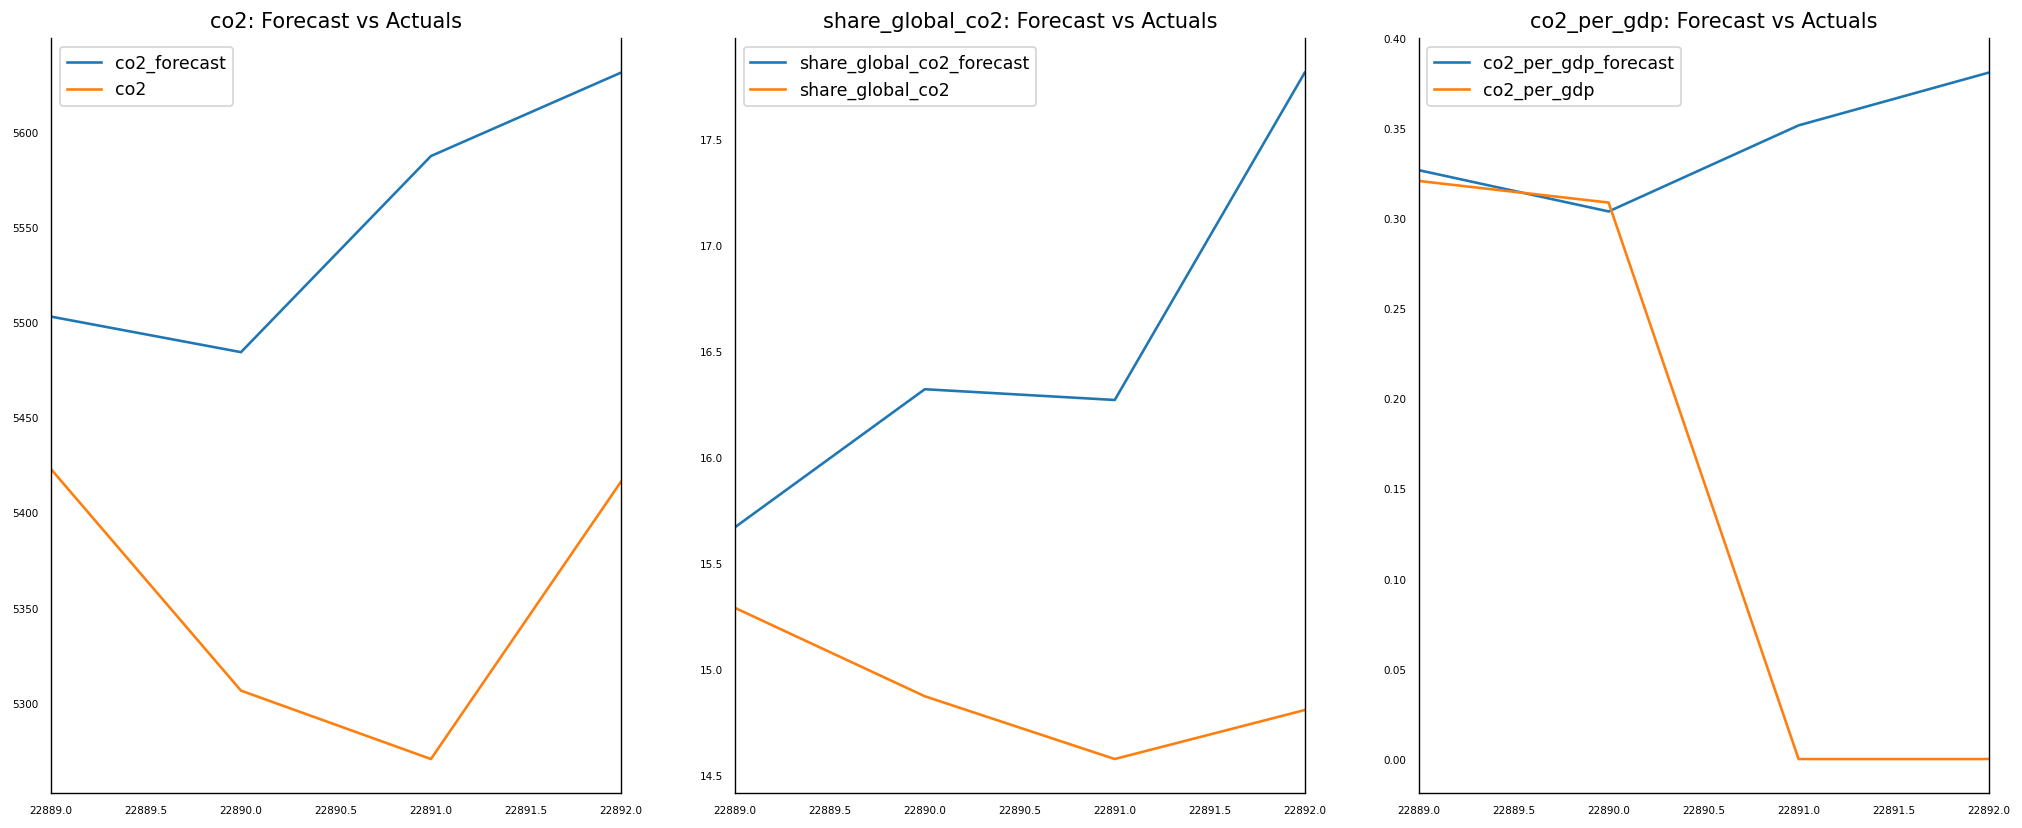

In [ ]:
fig, axes = plt.subplots(nrows=int(len(carbondf.columns)/2), ncols=3, dpi=125, figsize=(20,8))
for i, (col,ax) in enumerate(zip(carbondf.columns, axes.flatten())):
    carbondf_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    carbontest[col][-cnobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mae': mae,'rmse':rmse, 'minmax':minmax})

In [ ]:
print('Forecast Accuracy of: co2')
accuracy_prod = forecast_accuracy(carbondf_results['co2_forecast'].values, carbontest['co2'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: share global')
accuracy_prod = forecast_accuracy(carbondf_results['share_global_co2_forecast'].values, carbontest['share_global_co2'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))    

print('Forecast Accuracy of: co2 gdp')
accuracy_prod = forecast_accuracy(carbondf_results['co2_per_gdp_forecast'].values, carbontest['co2_per_gdp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: co2
mae :  197.3113
rmse :  214.7038
minmax :  0.0354
Forecast Accuracy of: share global
mae :  1.6317
rmse :  1.8803
minmax :  0.0964
Forecast Accuracy of: co2 gdp
mae :  0.186
rmse :  0.2594
minmax :  0.5086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


**Fossil Fuel**

In [ ]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/17UyI499mUj2nc6-Qp24NoS_wo-YSQHdw/view?usp=sharing'

In [ ]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fossilConsumption.csv')
fossildf = pd.read_csv('fossilConsumption.csv')

In [ ]:
fossildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190 entries, 0 to 5189
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 5190 non-null   object 
 1   Code                   4145 non-null   object 
 2   Year                   5190 non-null   int64  
 3   Coal Consumption - EJ  5170 non-null   float64
 4   Gas Consumption - EJ   5170 non-null   float64
 5   Oil Consumption - EJ   5184 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 243.4+ KB


In [ ]:
fossildf.rename(columns = {'Coal Consumption - EJ':'CoalConsumption', 'Gas Consumption - EJ':'GasConsumption', 
                              'Oil Consumption - EJ':'OilConsumption','Year':'year'}, inplace = True) 

In [ ]:
#fossildf.drop('Code', axis='columns', inplace=True)

In [ ]:
fossildf = fossildf[fossildf.Entity == 'United States']

In [ ]:
#dropping entity too since we don't need it on this. since it had been filtered
fossildf.drop(['Code','Entity','year'], axis='columns', inplace=True)

Year is also removed since it is causing some errors similarly to carbon when doing the modeling

In [ ]:
#ossildf['year']= pd.to_numeric(fossildf['year'], errors = 'coerce')

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    fossildf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in fossildf.columns:
        for r in fossildf.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            fossildf.loc[r, c] = min_p_value
    fossildf.columns = [var + '_x' for var in variables]
    fossildf.index = [var + '_y' for var in variables]
    return fossildf

grangers_causation_matrix(fossildf, variables = fossildf.columns)        

,CoalConsumption_x,GasConsumption_x,OilConsumption_x
CoalConsumption_y,1.0,0.0,0.0
GasConsumption_y,0.0,1.0,0.0
OilConsumption_y,0.0,0.0,1.0


Train and test

In [ ]:
fnobs = 4
fossiltrain, fossiltest = fossildf[0:-fnobs], fossildf[-fnobs:]
print(fossiltrain.shape)
print(fossiltest.shape)

(51, 3)
(4, 3)


Stationarity

In [ ]:
for name, column in fossiltrain.iteritems():
  adfuller_test(column, name = column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "CoalConsumption" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7495
 No. Lags Chosen       = 4
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.4058. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GasConsumption" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.605
 No. Lags Chosen       = 0
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.8698. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "OilConsumption" 
    -----------------------------------------------
 Nul

Coal is always non-stationary after differencing multiple times

In [ ]:
fossildifferenced = fossiltrain.diff().dropna()

In [ ]:
for name, column in fossildifferenced.iteritems():
  adfuller_test(column, name = column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "CoalConsumption" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8036
 No. Lags Chosen       = 3
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.8181. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GasConsumption" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4099
 No. Lags Chosen       = 0
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "OilConsumption" 
    -----------------------------------------------
 Null Hypothesis: Data has u

In [ ]:
fossilmodel = VAR(fossildifferenced)
for i in [1,2,3,4,5,6,7,8,9]:
    #result = fossilmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 2
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 3
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 4
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 5
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 6
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 7
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 8
AIC :  3.297221253789191
BIC :  4.467048334220518
FPE :  27.110473953130747
HQIC:  3.7678284134758817 

Lag Order = 9
AIC :  3.297221253789191
BIC :  4.46704833

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
fossilmodel_fitted = fossilmodel.fit(9)
fossilmodel_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     09:06:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.45490
Nobs:                     41.0000    HQIC:                  0.222587
Log likelihood:          -68.8850    FPE:                   0.864229
AIC:                     -1.05583    Det(Omega_mle):        0.181315
--------------------------------------------------------------------
Results for equation CoalConsumption
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.063336         0.250807            0.253           0.801
L1.CoalConsumption        -0.515552         0.282228           -1.827           0.068
L1.GasConsumption         -0.2

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fossilmodel_fitted.resid)

for col, val in zip(fossildf.columns, out):
    print(col, ':', round(val, 2))

CoalConsumption : 1.84
GasConsumption : 2.14
OilConsumption : 2.39


In [ ]:
fossillag_order = fossilmodel_fitted.k_ar
print(fossillag_order)
fforecast_input = fossildifferenced.values[-fossillag_order:]
fforecast_input

9


array([[ 0.30300223,  1.35217952, -0.24803352],
       [-0.36286277,  0.17110326, -2.64116915],
       [-2.70244158, -0.40547031, -1.91148614],
       [ 1.14539485,  1.10035214,  0.55878619],
       [-1.17889282,  0.36062495, -0.72106375],
       [-2.28479994,  1.07683083, -0.76806052],
       [ 0.66191994,  0.68040214,  0.57270907],
       [-0.04109543,  0.54855424,  0.24912102],
       [-2.45440165,  0.7674854 ,  0.71648491]])

In [ ]:
ffc = fossilmodel_fitted.forecast(y = fforecast_input, steps = fnobs)
fossilforecast = pd.DataFrame(ffc, index = fossildf.index[-fnobs:], columns = fossildf.columns + '_1d')
fossilforecast

,CoalConsumption_1d,GasConsumption_1d,OilConsumption_1d
4931,0.553921,0.888023,0.223616
4932,-0.007859,1.144113,1.311082
4933,-1.513450,1.506765,-1.954644
4934,-0.922241,-0.127212,-0.588612


In [ ]:
def invert_transformation(fossiltrain, fossilforecast, first_diff=False):
    fossildf_fc = fossilforecast.copy()
    columns = fossiltrain.columns
    for col in columns:
      # Roll back 1st Diff
      fossildf_fc[str(col)+'_forecast'] = fossiltrain[col].iloc[-1] + fossildf_fc[str(col)+'_1d'].cumsum()
    return fossildf_fc

In [ ]:
fossildf_results = invert_transformation(fossiltrain, fossilforecast, first_diff=True)        
fossildf_results.loc[:, ['CoalConsumption_forecast', 'GasConsumption_forecast', 'OilConsumption_forecast']]

,CoalConsumption_forecast,GasConsumption_forecast,OilConsumption_forecast
4931,16.138601,27.656885,35.883652
4932,16.130741,28.800998,37.194733
4933,14.617291,30.307763,35.240089
4934,13.695051,30.180551,34.651478


In [ ]:
fossildf.tail()

,CoalConsumption,GasConsumption,OilConsumption
4930,15.584680,26.768862,35.660035
4931,14.258668,26.967562,35.917927
4932,13.869334,26.639711,36.285099
4933,13.282051,29.517910,37.107278
4934,11.340643,30.479222,36.988039


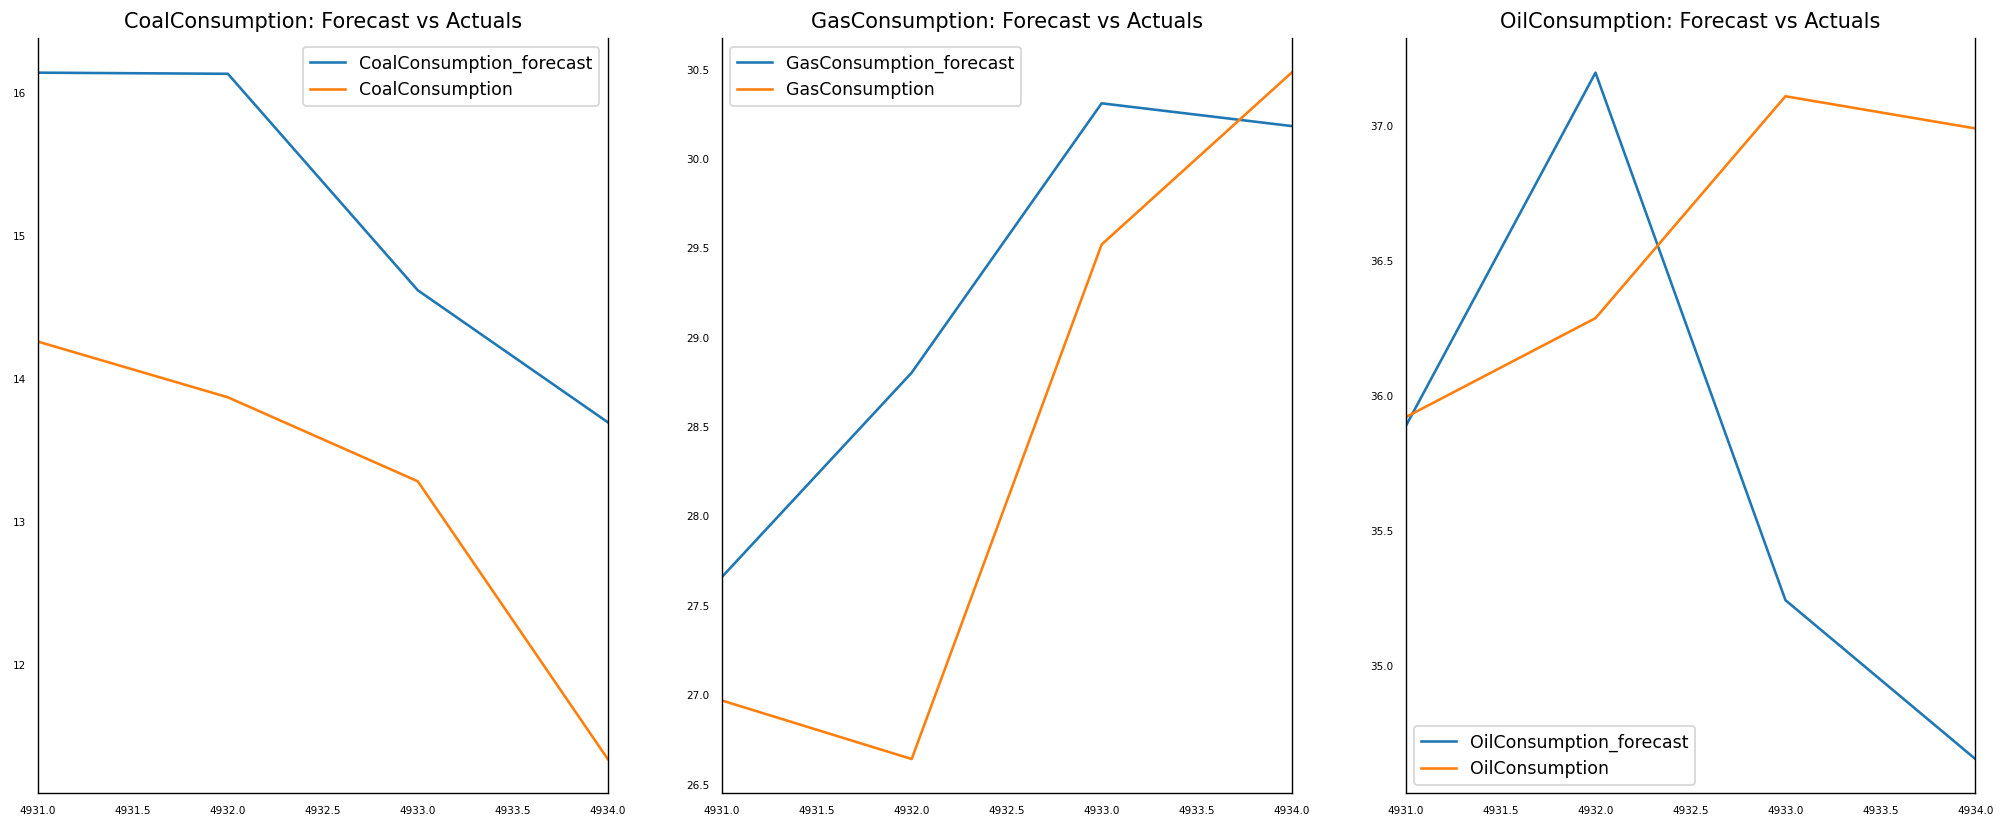

In [ ]:
fig, axes = plt.subplots(nrows=int(len(fossildf.columns)/2), ncols=3, dpi=125, figsize=(20,8))
for i, (col,ax) in enumerate(zip(fossildf.columns, axes.flatten())):
    fossildf_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    fossiltest[col][-fnobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [ ]:
print('Forecast Accuracy of: Oil Consumption')
accuracy_prod = forecast_accuracy(fossildf_results['OilConsumption_forecast'].values, fossiltest['OilConsumption'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: Gas Consumption')
accuracy_prod = forecast_accuracy(fossildf_results['GasConsumption_forecast'].values, fossiltest['GasConsumption'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: Coal Consumption')
accuracy_prod = forecast_accuracy(fossildf_results['CoalConsumption_forecast'].values, fossiltest['CoalConsumption'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Oil Consumption
mae :  1.2869
rmse :  1.5632
minmax :  0.0347
Forecast Accuracy of: Gas Consumption
mae :  0.9848
rmse :  1.2103
minmax :  0.034
Forecast Accuracy of: Coal Consumption
mae :  1.9577
rmse :  1.9984
minmax :  0.13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


**Crude Oil**

In [ ]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1bDmksCT2qU5xelMH8IpulvcfM9r9lnPz/view?usp=sharing'

In [ ]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('crudeoil.csv')
oildf = pd.read_csv('crudeoil.csv')

In [ ]:
from google.colab import files
oildf.to_csv('crudeoil.csv')

In [ ]:
oildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6244 entries, 0 to 6243
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6244 non-null   object 
 1   Open       5099 non-null   float64
 2   High       5099 non-null   float64
 3   Low        5099 non-null   float64
 4   Close      5099 non-null   float64
 5   Adj Close  5099 non-null   float64
 6   Volume     5099 non-null   float64
dtypes: float64(6), object(1)
memory usage: 341.6+ KB


In [ ]:
print(oildf.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
oildf = oildf.dropna()

In [ ]:
oildf['Date']= pd.to_numeric(oildf['Close'], errors = 'coerce')
#df['a'] = df['a'].astype(float, errors = 'raise')
#df['DataFrame Column'] = pd.to_numeric(df['DataFrame Column'],errors='coerce')


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    oildf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in oildf.columns:
        for r in oildf.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            oildf.loc[r, c] = min_p_value
    oildf.columns = [var + '_x' for var in variables]
    oildf.index = [var + '_y' for var in variables]
    return oildf

grangers_causation_matrix(oildf, variables = oildf.columns)        

,Date_x,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Date_y,1.0,0.0,0.0000,0.0,1.0,1.0,0.0000
Open_y,0.0,1.0,0.0000,0.0,0.0,0.0,0.0000
High_y,0.0,0.0,1.0000,0.0,0.0,0.0,0.0002
Low_y,0.0,0.0,0.0000,1.0,0.0,0.0,0.0000
Close_y,1.0,0.0,0.0000,0.0,1.0,1.0,0.0000
Adj Close_y,1.0,0.0,0.0000,0.0,1.0,1.0,0.0000
Volume_y,0.0,0.0,0.0001,0.0,0.0,0.0,1.0000


train and test

In [ ]:
onobs = 4
oiltrain, oiltest = oildf[0:-onobs], oildf[-onobs:]

# Check size
print(oiltrain.shape)
print(oiltest.shape)

(5095, 7)
(4, 7)


checking for stationarity

In [ ]:
# ADF Test on each column
for name, column in oiltrain.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Date" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1847
 No. Lags Chosen       = 12
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2118. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9925
 No. Lags Chosen       = 4
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2899. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [ ]:
 #First difference
oildifferenced = oiltrain.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in oildifferenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Date" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.1357
 No. Lags Chosen       = 5
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -35.415
 No. Lags Chosen       = 3
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

order of var model

unsuccessful since all lag are not working

In [ ]:
oilmodel = VAR(oildifferenced)
for i in [9]:
    result = oilmodel.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')